In [2]:
### ==> 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchinfo import summary


In [3]:
### ===> 이미지 데이터 준비
filename = "../data/img/cat05.jpg"


In [6]:
imgNP = cv2.imread(filename) / 255
imgNP2 = cv2.resize(imgNP, (50, 50))
print(imgNP.shape, imgNP.ndim, "---", imgNP2.shape, imgNP2.ndim)

grayNP = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) / 255
grayNP2 = cv2.resize(grayNP, (50, 50))
print(grayNP.shape, grayNP.ndim, "---", grayNP2.shape, grayNP2.ndim)


(185, 273, 3) 3 --- (50, 50, 3) 3
(185, 273) 2 --- (50, 50) 2


In [8]:
### numpy ===> FloatTensor 변환
colorT = torch.FloatTensor(imgNP2)
grayT = torch.FloatTensor(grayNP2)


In [9]:
print(f"[colorT] shape : {colorT.shape}, ndim : {colorT.ndim}D")
print(f"[grayT] shape : {grayT.shape}, ndim : {grayT.ndim}D")


[colorT] shape : torch.Size([50, 50, 3]), ndim : 3D
[grayT] shape : torch.Size([50, 50]), ndim : 2D


In [10]:
### Pytorch 이미지 데이터 형식 (C, H, W) ==>
colorT = colorT.permute(2, 0, 1)
grayT = grayT.unsqueeze(0)


In [11]:
print(f"[colorT] shape : {colorT.shape}, ndim : {colorT.ndim}D")
print(f"[grayT] shape : {grayT.shape}, ndim : {grayT.ndim}D")


[colorT] shape : torch.Size([3, 50, 50]), ndim : 3D
[grayT] shape : torch.Size([1, 50, 50]), ndim : 3D


### ===> CNN Layer 살펴보기


In [71]:
### ===> 이미지 데이터로 Conv2D
### [1] 흑백이미지
conLayer = nn.Conv2d(
    in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=0
)  # 입력 출력 shape 다름
conLayer2 = nn.Conv2d(
    in_channels=5, out_channels=3, kernel_size=3, stride=1, padding="same"
)  # 입력 출력 shape 동일


In [72]:
output = conLayer(grayT)
output2 = conLayer2(output)

print(f"[output] {output.shape}, output2 : {output2.shape}")


[output] torch.Size([5, 48, 48]), output2 : torch.Size([3, 48, 48])


In [73]:
### ===> Polling Layer : Conv층에서 추출한 특징을 다운샘플링 진행
### 결과 shape : H, W 줄어듬, C는 그대로
pol1 = nn.MaxPool2d(3)
pol2 = nn.MaxPool2d(3, 2)


In [74]:
### convXD + AF => F.relu()
relu1 = F.relu(output)
relu1.shape

relu2 = F.relu(conLayer2(relu1))
relu2.shape


torch.Size([3, 48, 48])

In [75]:
# 2번째 Conv2D + AF 결과인 피쳐맵 전달
fm1 = pol1(relu2)
fm1.shape


torch.Size([3, 16, 16])

In [76]:
fm2 = pol2(relu2)
fm2.shape


torch.Size([3, 23, 23])

#### 추출된 Feature Map 확인


In [77]:
## Conv2D + Conv2D + Polling
print(f"===> [input] {grayT.shape}")

output1 = conLayer(grayT)
relu1 = F.relu(output1)
print(f"===> [relu1] {relu1.shape}")

output2 = conLayer2(relu1)
relu2 = F.relu(output2)
print(f"===> [relu2] {relu2.shape}")

mp1 = pol1(relu2)
print(f"===> [mp1] {mp1.shape}")


===> [input] torch.Size([1, 50, 50])
===> [relu1] torch.Size([5, 48, 48])
===> [relu2] torch.Size([3, 48, 48])
===> [mp1] torch.Size([3, 16, 16])


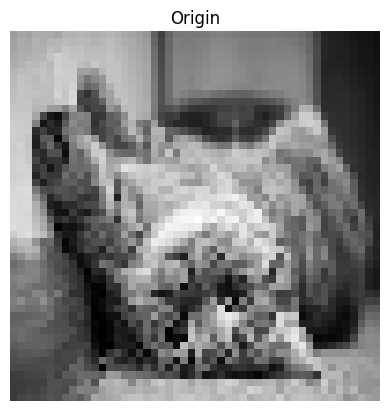

In [82]:
#### ===> 시각화
import matplotlib.pyplot as plt

### 입력 그림
grayImg = grayT.squeeze()

plt.imshow(grayImg, cmap="gray")
plt.title("Origin")
plt.axis("off")
plt.show()


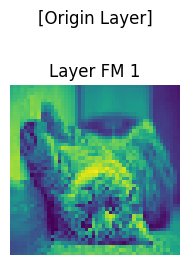

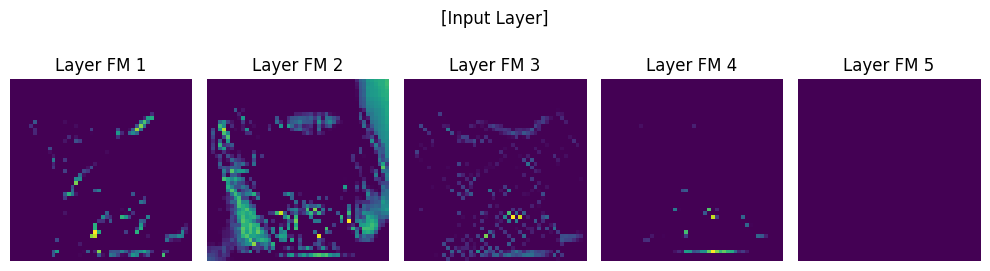

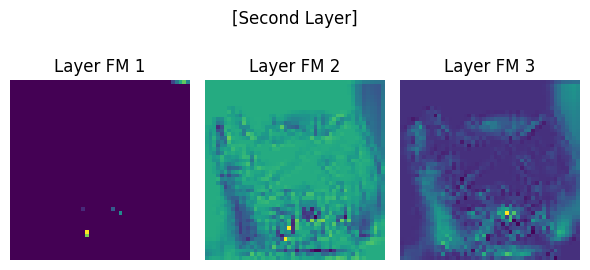

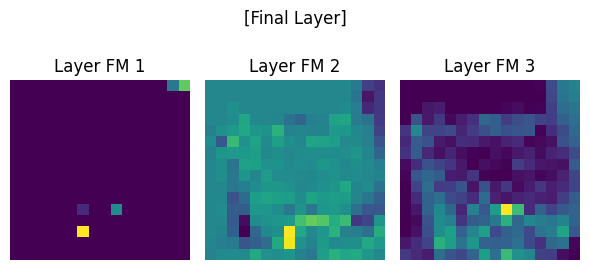

In [115]:
### 첫번째 Conv2D Layer 추출 피쳐맵
def print_featureMap(fm_tensor, cols, layer_name):
    # print(f'[{layer_name} Layer]')
    plt.figure(figsize=(cols * 2, 3))
    for idx in range(fm_tensor.shape[0]):
        plt.subplot(1, cols, idx + 1)
        plt.imshow(fm_tensor[idx].detach())
        plt.title(f"Layer FM {idx+1}")
        plt.axis("off")
    plt.suptitle(f"[{layer_name} Layer]")
    plt.tight_layout()
    plt.show()


print_featureMap(grayT, 1, "Origin")
print_featureMap(relu1, 5, "Input")
print_featureMap(relu2, 3, "Second")
print_featureMap(mp1, 3, "Final")


In [110]:
mp1.shape[0] * mp1.shape[1] * mp1.shape[2]


768